<a href="https://colab.research.google.com/github/btho733/Belvin-Personal_Projects/blob/master/Project06_MONAIBootcamp/BelvinWorkingCopy_lab2_end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: End to end model training and validation with Pytorch, Ignite and MONAI
---
## Overview

This notebook takes you through the end to end workflow using for training a deep learning model.  You'll do the following:
- Download the MedNIST Dataset
- Explore the data
- Prepare training, validation, and test datasets
- Use MONAI transforms, dataset, and dataloader
- Define network, optimizer, and loss function
- Train your model with a standard pytorch training loop
- Plot your training metrics
- Evaluate your model on a test set
- Understand your results
- Make some improvements
  - Revisit model training using ignite and MONAI features
  - Sort out problems limiting reproducability
  - Rework dataset partitioning 

## Import everything that we'll need from MONAI
Initial imports of the various packages used to create a model using pytorch and MONAI.

In [1]:
!pip install -qU "monai[ignite]==0.3.0rc2"

%matplotlib inline

import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch

import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import compute_roc_auc
from monai.networks.nets import densenet121
from monai.transforms import (
    AddChannel,
    Compose,
    LoadPNG,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.utils import set_determinism

print_config()

     |████████████████████████████████| 296kB 9.7MB/s 
     |████████████████████████████████| 112kB 20.1MB/s 
MONAI version: 0.3.0rc2
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
Numpy version: 1.18.5
Pytorch version: 1.6.0+cu101

Optional dependencies:
Pytorch Ignite version: 0.3.0
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.0.0
Tensorboard version: 2.3.0
gdown version: 3.6.4
TorchVision version: 0.7.0+cu101
ITK version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory
We'll create a temporary directory for all the MONAI data we're going to be using called MONAI_DATA_DIRECTORY.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp19fkgvcm


## Download the MedNIST dataset
The `MedNIST` dataset was gathered from several sets from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions),
[the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4),
and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The dataset is kindly made available by [Dr. Bradley J. Erickson M.D., Ph.D.](https://www.mayo.edu/research/labs/radiology-informatics/overview) (Department of Radiology, Mayo Clinic)
under the Creative Commons [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/).

If you use the MedNIST dataset, please acknowledge the source.

We're going to download this dataset below and extract it into our temporary MONAI Data Directory.

In [3]:
resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

61841408/61834679 Downloading MedNIST.tar.gz: [==============================]
downloaded file: /tmp/tmp19fkgvcm/MedNIST.tar.gz.
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.


### Set deterministic training for reproducibility
[set_determinism](https://docs.monai.io/en/latest/utils.html?highlight=set_determinism#monai.utils.misc.set_determinism) will set the random seeds in both Numpy and PyTorch to ensure reproducibility. We'll see later that we need to go a little bit further to ensure reproducibility in a jupyter notebook

In [4]:
set_determinism(seed=0)

## Read the image filenames from the dataset folders

When using a dataset, you want to understand the basics of the images, labels, and more.  We'll start off by showing some of those basic statistics for MedNIST.

We'll see that 6 different folders are representing 6 different categories: Hand, AbdomenCT, CXR, ChestCT, BreastMRI, HeadCT.  We'll be using each of these categories as our label names. 

In [5]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)
image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []
for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


## Randomly pick images from the dataset to visualize and check

We want to understand what the images we're using look like, so we'll start by visualizing a few random images.

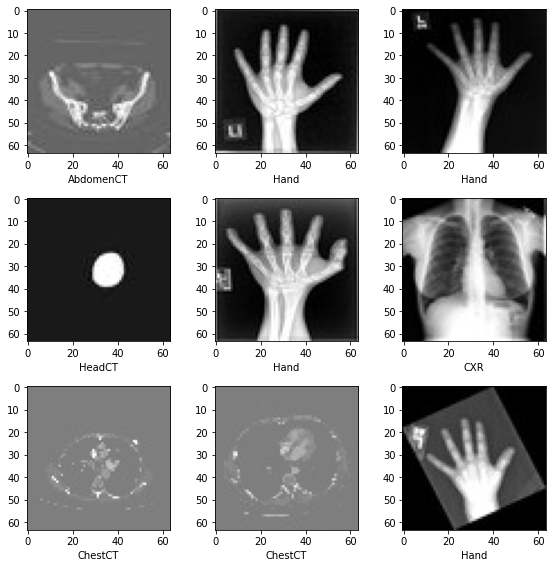

In [6]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

## Prepare training, validation, and test data lists

We want to split the data into 3 different sets, one for training, one for validation, and one for testing.  We'll use a ratio of 80/10/10 for those sets.

In [7]:
val_frac = 0.1
test_frac = 0.1
train_x = list()
train_y = list()
val_x = list()
val_y = list()
test_x = list()
test_y = list()

for i in range(num_total):
    rann = np.random.random()
    if rann < val_frac:
        val_x.append(image_files_list[i])
        val_y.append(image_class[i])
    elif rann < test_frac + val_frac:
        test_x.append(image_files_list[i])
        test_y.append(image_class[i])
    else:
        train_x.append(image_files_list[i])
        train_y.append(image_class[i])

print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")

Training count: 47156, Validation count: 5913, Test count: 5885


## Define MONAI transforms, Dataset and Dataloader to pre-process data

We'll define our transform using `Compose`.  In this Array of Transforms, we'll load the image, add a channel, scale its intensity, utilize a few random functions and finally create a tensor.

In [8]:
train_transforms = Compose(
    [
        LoadPNG(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
    ]
)

val_transforms = Compose([LoadPNG(image_only=True), AddChannel(), ScaleIntensity(), ToTensor()])

## Initialise the datasets and loaders for training, validation and test sets
 * Define a simple dataset, that we'll call `MedNISTDataset`, that groups:
   * Images
   * Labels
   * The transforms that are to be run on the images and labels
 * Create three instances of this dataset:
   * One for training
   * One for validation
   * One for testing
   
We'll use a batch size of 512 and employ 10 workers to load the data.

In [9]:
batch_size = 512
num_workers = 10

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

## Define network and optimizer

1. Set `learning_rate` for how much the model is updated per step
1. The fetch a pytorch `device` for the GPU
1. Instantiate a [densenet121](https://docs.monai.io/en/latest/networks.html?highlight=densenet#monai.networks.nets.densenet121) model instance and 'send' it to the GPU using `device`
  * This is a standard MONAI implementation; it is capable of 2D and 3D operation but here we are using it in 2D mode
1. We'll make use of the Adam optimizer

In [10]:
learning_rate = 1e-5
device = torch.device("cuda:0")
net = densenet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)

## Network training
We are hand-rolling a basic pytorch training loop here:
 * standard pytorch training loop
   * step through each training epoch, running through the training set in batches
   * after each epoch, run a validation pass, evaluating the network
   * if it shows improved performance, save out the model weights
 * later we will revisit training loops in a more Ignite / MONAI fashion

In [11]:
epoch_num = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    epoch_loss = 0
    step = 1

    steps_per_epoch = len(train_ds) // train_loader.batch_size

    # put the network in train mode; this tells the network and its modules to
    # enable training elements such as normalisation and dropout, where applicable
    net.train()
    for batch_data in train_loader:

        # move the data to the GPU
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # prepare the gradients for this step's back propagation
        optimizer.zero_grad()
        
        # run the network forwards
        outputs = net(inputs)
        
        # run the loss function on the outputs
        loss = loss_function(outputs, labels)
        
        # compute the gradients
        loss.backward()
        
        # tell the optimizer to update the weights according to the gradients
        # and its internal optimisation strategy
        optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size + 1}, training_loss: {loss.item():.4f}")
        step += 1

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # after each epoch, run our metrics to evaluate it, and, if they are an improvement,
    # save the model out
    
    # switch off training features of the network for this pass
    net.eval()

    # 'with torch.no_grad()' switches off gradient calculation for the scope of its context
    with torch.no_grad():
        # create lists to which we will concatenate the the validation results
        images = list()
        labels = list()

        # iterate over each batch of images and run them through the network in evaluation mode
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

            # run the network
            val_pred = net(val_images)

            images.append(val_pred)
            labels.append(val_labels)

        # concatenate the predicted labels with each other and the actual labels with each other
        y_pred = torch.cat(images)
        y = torch.cat(labels)

        # we are using the area under the receiver operating characteristic (ROC) curve to determine
        # whether this epoch has improved the best performance of the network so far, in which case
        # we save the network in this state
        auc_metric = compute_roc_auc(y_pred, y, to_onehot_y=True, softmax=True)
        metric_values.append(auc_metric)
        acc_value = torch.eq(y_pred.argmax(dim=1), y)
        acc_metric = acc_value.sum().item() / len(acc_value)
        if auc_metric > best_metric:
            best_metric = auc_metric
            best_metric_epoch = epoch + 1
            torch.save(net.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
            print("saved new best metric network")
        print(
            f"current epoch: {epoch + 1} current AUC: {auc_metric:.4f} /"
            f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f} /"
            f" at epoch: {best_metric_epoch}"
        )

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/4
1/93, training_loss: 1.7820
2/93, training_loss: 1.7680
3/93, training_loss: 1.7382
4/93, training_loss: 1.7196
5/93, training_loss: 1.6798
6/93, training_loss: 1.6671
7/93, training_loss: 1.6366
8/93, training_loss: 1.6149
9/93, training_loss: 1.5916
10/93, training_loss: 1.5591
11/93, training_loss: 1.5596
12/93, training_loss: 1.5183
13/93, training_loss: 1.5020
14/93, training_loss: 1.4802
15/93, training_loss: 1.4616
16/93, training_loss: 1.4445
17/93, training_loss: 1.4071
18/93, training_loss: 1.3933
19/93, training_loss: 1.3637
20/93, training_loss: 1.3420
21/93, training_loss: 1.3389
22/93, training_loss: 1.3089
23/93, training_loss: 1.2929
24/93, training_loss: 1.2683
25/93, training_loss: 1.2856
26/93, training_loss: 1.2432
27/93, training_loss: 1.2519
28/93, training_loss: 1.2180
29/93, training_loss: 1.1988
30/93, training_loss: 1.1552
31/93, training_loss: 1.1491
32/93, training_loss: 1.1399
33/93, training_loss: 1.1418
34/93, training_loss: 1.1226
35

## Plot the loss and metric

Once we're done training we want to visualize our Loss and Accuracy.

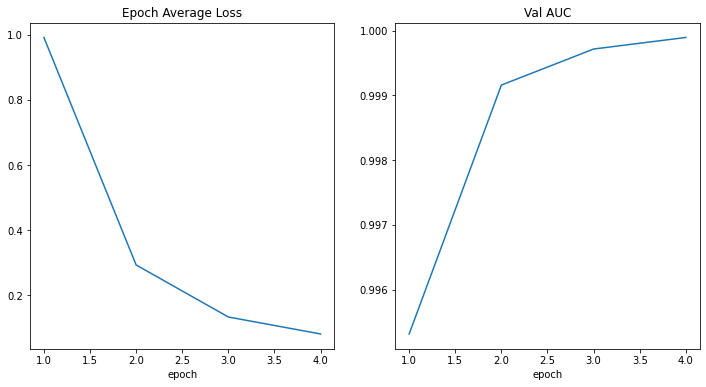

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Evaluate the model on the test dataset

After training and validation, we now have the best model as determined by the validation dataset.  But now we need to evaluate the model on the test dataset to check whether the final model is robust and not over-fitting.  We'll use these predictions to generate a classification report.

In [13]:
net.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
net.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data[0].to(device),
            test_data[1].to(device),
        )
        pred = net(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

## Some light analytics - classification report

We'll utilize scikit-learn's classification report to get the precision, recall, and f1-score for each category.

In [14]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


              precision    recall  f1-score   support

   AbdomenCT     0.9806    0.9886    0.9846       969
   BreastMRI     0.9957    0.9862    0.9910       944
         CXR     0.9990    0.9897    0.9943       973
     ChestCT     0.9969    1.0000    0.9984       959
        Hand     0.9915    0.9943    0.9929      1055
      HeadCT     0.9879    0.9919    0.9899       985

    accuracy                         0.9918      5885
   macro avg     0.9919    0.9918    0.9918      5885
weighted avg     0.9919    0.9918    0.9918      5885



## Some light analytics - confusion matrix

Let's also create a confusion matrix to get a better understanding of the failure cases

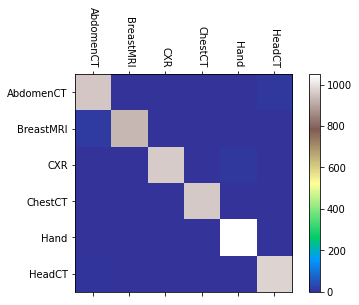

In [15]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true, y_pred)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix(y_true, y_pred), cmap="terrain", interpolation='nearest')
fig.colorbar(cax)

ax.set_xticklabels(['']+class_names, rotation=270)
ax.set_yticklabels(['']+class_names)

plt.show()

## Let's make some changes
Everything that we have done so far uses MONAI with pytorch in a very vanilla fashion. The initial training / validation loop is written to show you the nuts and bolts of pytorch. Now let's explore starting the move towards [ignite](https://pytorch.org/ignite/) and features of MONAI designed to work with it. We'll also fix up a couple of outstanding issues that the notebook has in its current form.

* MONAI-specific
  * Making use of Ignite
* Miscellaneous
  * Issues with determinism
  * Improving dataset partitioning

In [16]:
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.handlers import ModelCheckpoint
from ignite.metrics import Accuracy
from monai.handlers import ROCAUC

step = 1
iter_losses=[]
batch_sizes=[]
epoch_loss_values = []
metric_values = []

iter_losses=[]
epoch_loss_values = []
metric_values = []

# Training

# this trainer takes care of the training loop for us
trainer = create_supervised_trainer(net, optimizer, loss_function, device, False)

# calculate the number of steps per epoch up front
steps_per_epoch = len(train_ds) // train_loader.batch_size
if len(train_ds) % train_loader.batch_size != 0:
    steps_per_epoch += 1


# create a handler for recording the loss after each input. Improve upon our earlier example
# by also recording the batch size, so we can perform a weighted average for the overall average
# loss
@trainer.on(Events.ITERATION_COMPLETED)
def _end_iter(engine):
    global step
    loss = engine.state.output
    batch_len = len(engine.state.batch[0])
    epoch = engine.state.epoch
    epoch_len = engine.state.max_epochs
    iter_losses.append(loss)
    batch_sizes.append(batch_len)
    print(f'epoch {epoch}/{epoch_len}, step {step}/{steps_per_epoch}, training_loss = {loss:.4f}')    
    step += 1
    
# Validation

val_metrics = {'accuracy': Accuracy(), 'rocauc': ROCAUC(to_onehot_y=True,softmax=True)}
evaluator = create_supervised_evaluator(net, val_metrics, device, True)

# validation is run every n training epochs in response to the trainer completing
# an epoch. Here we use the decorator syntax to add a function that runs it to the
# EPOCH_COMPLETED event
@trainer.on(Events.EPOCH_COMPLETED)
def run_validation(engine):
    global step
    evaluator.run(val_loader)

    # the overall average loss must be weighted by batch size
    overall_average_loss = np.average(iter_losses, weights=batch_sizes)
    epoch_loss_values.append(overall_average_loss)

    # clear the contents of iter_losses and batch_sizes for the next epoch
    del iter_losses[:]
    del batch_sizes[:]
    
    # fetch and report the validation metrics
    acc = evaluator.state.metrics['accuracy']
    roc = evaluator.state.metrics['rocauc']
    metric_values.append(roc)
    print(f"evaluation for epoch {engine.state.epoch}, accuracy = {acc:.4f}, rocauc = {roc:.4f}")

    # reset step for the next epoch
    step = 1
    
# create a checkpoint handler to save the network weights based on the area under the ROC curve
# as before
def _score(_):
    return metric_values[-1]

# create a model checkpointer to save the network
checkpoint_handler = ModelCheckpoint(root_dir, filename_prefix='best_metric_model', score_name='',
                                     n_saved=1, require_empty=False, score_function=_score)

# handlers are attached to events in trainers and evaluators
trainer.add_event_handler(event_name=Events.EPOCH_COMPLETED,
                          handler=checkpoint_handler, to_save={'net': net})
# train (and evaluate) the network, Ignite-style!
train_epochs = 4
state = trainer.run(train_loader, train_epochs)

best_rocauc = max(metric_values)
print(f"train completed, best_metric: {best_rocauc:.4f} at epoch: {metric_values.index(best_rocauc)}")

epoch 1/4, step 1/93, training_loss = 0.0579
epoch 1/4, step 2/93, training_loss = 0.0655
epoch 1/4, step 3/93, training_loss = 0.0626
epoch 1/4, step 4/93, training_loss = 0.0700
epoch 1/4, step 5/93, training_loss = 0.0702
epoch 1/4, step 6/93, training_loss = 0.0694
epoch 1/4, step 7/93, training_loss = 0.0543
epoch 1/4, step 8/93, training_loss = 0.0606
epoch 1/4, step 9/93, training_loss = 0.0620
epoch 1/4, step 10/93, training_loss = 0.0804
epoch 1/4, step 11/93, training_loss = 0.0818
epoch 1/4, step 12/93, training_loss = 0.0612
epoch 1/4, step 13/93, training_loss = 0.0636
epoch 1/4, step 14/93, training_loss = 0.0736
epoch 1/4, step 15/93, training_loss = 0.0651
epoch 1/4, step 16/93, training_loss = 0.0600
epoch 1/4, step 17/93, training_loss = 0.0530
epoch 1/4, step 18/93, training_loss = 0.0657
epoch 1/4, step 19/93, training_loss = 0.0558
epoch 1/4, step 20/93, training_loss = 0.0592
epoch 1/4, step 21/93, training_loss = 0.0693
epoch 1/4, step 22/93, training_loss = 0.04

# Issues with determinism
* MONAI provides `monai.utils.set_determinism` for replicable training
  * Easy to accidentally defeat, especially in a jupyter / IPython notebook
* How many uses of `numpy.random`'s underlying global instance does this notebook have?
  * Dataset partitioning
  * Image previewing
  * Transforms
    * MONAI transforms with randomised behaviour can be given / told to create their own internal `numpy.random.RandomState` instances


In [17]:
# Setting up transforms, revisited

rseed = 12345678

train_transforms = Compose(
    [
        LoadPNG(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True).set_random_state(rseed),
        RandFlip(spatial_axis=0, prob=0.5).set_random_state(rseed),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5).set_random_state(rseed),
        ToTensor(),
    ]
)

val_transforms = Compose([LoadPNG(image_only=True), AddChannel(), ScaleIntensity(), ToTensor()])

# Improving dataset partitioning
  * Current code results in random numbers of images / labels each time it is run
  * np.shuffle to the rescue

In [18]:
from math import floor

# make this selection deterministic and controllable by seed
dataset_seed = 12345678
r = np.random.RandomState(dataset_seed)

# calculate the number of images we want for the validation and test groups
validation_proportion = 0.1
test_proportion = 0.1
validation_count = floor(validation_proportion * num_total)
test_count = floor(test_proportion * num_total)

groups = np.zeros(num_total, dtype=np.int32)

# set the appropriate number of '1's for the validation dataset
groups[:validation_count] = 1

# then set the appropriate number of '2's for the test dataset
groups[validation_count:validation_count + test_count] = 2

# Shuffle the sequence so that 
r.shuffle(groups)

image_sets = list(), list(), list()
label_sets = list(), list(), list()

for n in range(num_total):
    image_sets[groups[n]].append(image_files_list[n])
    label_sets[groups[n]].append(image_class[n])
    
train_x, val_x, test_x = image_sets
train_y, val_y, test_y = label_sets
print(len(train_x), len(val_x), len(test_x))

47164 5895 5895


## Now try running the notebook!
 * Try out the pytorch training loop and the ignite & monai style training loop
 * Make the entire notebook work deterministically by replacing all implicit use of the global numpy RandomState with explicit RandomState instances
 * Replace the dataset partitioning with the improved version
 * Experiment with adding new metrics to the Ignite training / validation loop

## Summary

In this notebook, we went through an end-to-end workflow to train the MedNIST dataset using a densenet121 network.  Along the way, you did the following:
- Learned about the MedNIST Data and downloaded it
- Visualized the data to understand the images we're using
- Setup the datasets for use in the model training
- Defined our transforms, datasets, network, and optimizers
- Trained a densenet model and saved the best model as determined by the validation accuracy
- Plotted your training results
- Evaluated your model against the test set
- Ran your final predictions through a classification report to understand more about your final results

For full API documentation, please visit https://docs.monai.io.

## Tidy everything up

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)